### Websites to Scrape:
1. https://app.powerbi.com/view?r=eyJrIjoiZGNhZGIwM2QtYTM2NC00ZjRiLTliNmMtZjdiMGQ2ZDRjYjg2IiwidCI6IjM4MmZiOGIwLTRkYzMtNDEwNy04MGJkLTM1OTViMjQzMmZhZSIsImMiOjZ9
2. 

In [1]:
from requests import get
import requests
from bs4 import BeautifulSoup
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
import datetime
import pandas as pd
import us
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

### Cities

In [26]:
r = requests.get("https://ballotpedia.org/Changes_to_policing_policy_in_the_states_and_100_largest_cities,_2020#Local_responses_in_100_largest_cities")

In [84]:
html = r.content
soup = BeautifulSoup(html, 'html5lib')

In [98]:
cities = []
state = []
date = []
text = []

city_policies = soup.find_all('span', class_='mw-headline')[72:151]
for i in range(len(city_policies)):
    # city
    try:
        city = city_policies[i].a['title']
        cities.append(city)
    except TypeError:
        pass

In [104]:
cities

In [118]:
# from selenium import webdriver
# import pandas as pd


# driver = webdriver.Chrome('C:/chromedriver_win32/chromedriver.exe')
# driver.get("http://useofforceproject.org/#review")

# html = driver.page_source

# tables = pd.read_html(html)
# data = tables[1]

# driver.close()

In [120]:
# html

In [122]:
city_policies[0].a['title']

'Atlanta, Georgia'

In [2]:
# city_policies

In [74]:
# soup.find_all('td')[25:]

In [76]:
# soup.find_all('p')[25:]

In [3]:
# soup.find_all('span', class_='mw-headline')[72:151]

In [4]:
# soup

### States:
- Data scraped from: https://www.ncsl.org/research/civil-and-criminal-justice/legislative-responses-for-policing.aspx

In [669]:
%%time
from tqdm.notebook import tqdm, trange
import time

df_pol = []

date = "_0402"

for year, div_id in tqdm({2020: "dnn_ctr93953_StateNetDB_linkList", 2021: "dnn_ctr92166_StateNetDB_linkList"}.items()):
    # read html page
    soup = BeautifulSoup(open(fr"C:/Users/Leonardo/OneDrive/Documents/TU_Delft/CodingProjects/PoliceBrutality/data/raw/NCLS/{year}_policies{date}.html"), "html.parser")
    # clean html and convert policies to list of strings
    policies = soup.find_all('div', id = div_id)[0].text.split('\n')
    policies_str = list(filter(None,[el.replace('  ','') for el in list(filter(None, policies))]))
    policies_str_cl = [el for el in policies_str if "Text Lookup" not in el]
    print("There were", len([policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']), f"state policies related to policing in {year}.")
    # extract all info of interest
    policy_id = [policies_str_cl[i-3] for i, x in enumerate(policies_str_cl) if x == 'Status:']
    state = [el[:2] for el in policy_id]
    year = [el for el in policies_str_cl if el.startswith("2021") or el.startswith("2020")]
    status = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']
    DOLA = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Date of Last Action:*\xa0']
    author = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Author:']
    topics = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Topics: ']
    summary = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Summary: ']
    history = [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']

    # make dataframe
    df_data = {"policy_id": policy_id, "state": state, "year": year, "status": status, 
               "date_of_last_action": DOLA, "author": author, "topics": topics, "summary": summary, "history": history}
    df = pd.DataFrame.from_dict(df_data)
    df_pol.append(df)
    
df_policies = pd.concat(df_pol).reset_index().drop("index", axis=1)
df_policies.to_csv(f"../data/raw/NCLS/2020_2021_state_policies{date}.csv")
print("In total, there were", len(df_policies), f"state policies related to policing since the murder of George Floyd on May, 25th, 2020, as of", date)

There were 744 state policies related to policing in 2020.
There were 1864 state policies related to policing in 2021.

In total, there were 2608 state policies related to policing since the murder of George Floyd on May, 25th, 2020, as of _0402
Wall time: 17.4 s


In [7]:
print("ADOPTION: Approval or acceptance; usually applied to amendments, committee reports or resolutions.")
print("")
print("ACT: Legislation enacted into law. A bill that has passed both houses of the legislature, been enrolled, ratified, signed by the governor or passed over the governor's office, and printed. It is a permanent measure, having the force of law until repealed.")
print("Local act: Legislation enacted into law that has limited application.")
print("Private act: Legislation enacted into law that has limited application.")
print("Public act: Legislation enacted into law that applies to the public at large.")
print("")
print("VETO: Action by the governor to disapprove a measure.")
print("")
print("from: https://www.ncsl.org/research/about-state-legislatures/glossary-of-legislative-terms.aspx")

ADOPTION: Approval or acceptance; usually applied to amendments, committee reports or resolutions.

ACT: Legislation enacted into law. A bill that has passed both houses of the legislature, been enrolled, ratified, signed by the governor or passed over the governor's office, and printed. It is a permanent measure, having the force of law until repealed.
Local act: Legislation enacted into law that has limited application.
Private act: Legislation enacted into law that has limited application.
Public act: Legislation enacted into law that applies to the public at large.

VETO: Action by the governor to disapprove a measure.

from: https://www.ncsl.org/research/about-state-legislatures/glossary-of-legislative-terms.aspx


In [670]:
df_policies = pd.read_csv(f"../data/raw/NCLS/2020_2021_state_policies{date}.csv").drop("Unnamed: 0", axis=1)

In [671]:
df_policies['status_cl'] = df_policies.status.str.split('-').str[0].str.strip()
df_policies['status_cl'][df_policies['status_cl']==""] = "No Status"
df_policies['count'] = 1

unique_topics = list(set([word.strip() for sublist in list(df_policies['topics'].str.split(",").values) for word in sublist if word != "Summary: "]))
# # columns for each topic
# for topic in range(1,13):
#     df_policies[f'topic_{topic}'] = df_policies['topics'].str.split(",").str[topic]

# columns for each topic
for topic in unique_topics:
    df_policies[topic] = 0
    df_policies[topic][df_policies["topics"].str.contains(topic)] = 1
    
state_policies_stat = df_policies.groupby(["status_cl", 'state']).sum().reset_index()#.drop("year", axis=1)

# total number of policies per state
state_policies_stat['tot_policies'] = 0
state_policies_stat['tot_failed'] = 0
state_policies_stat['tot_success'] = 0
state_policies_stat['tot_outcome'] = 0

for state in state_policies_stat['state'].unique():
    state_policies_stat['tot_policies'][state_policies_stat['state'] == state] = state_policies_stat[state_policies_stat['state'] == state]['count'].sum()
    state_policies_stat['tot_failed'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Vetoed', 'Failed']))]['count'].sum()
    state_policies_stat['tot_success'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Enacted', 'Adopted']))]['count'].sum()
    state_policies_stat['tot_outcome'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Vetoed', 'Failed', 'Enacted', 'Adopted']))]['count'].sum()

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCop

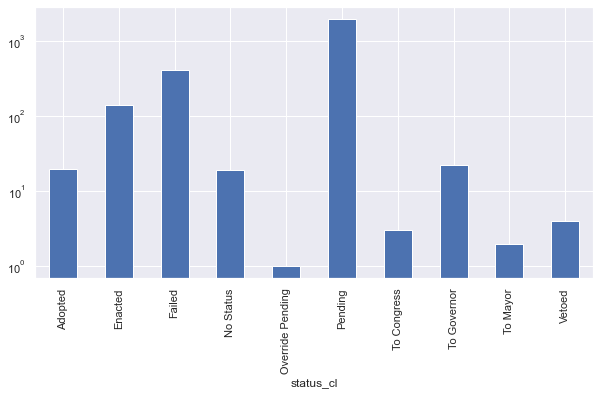

In [672]:
fig, ax = plt.subplots(figsize=(10,5)) ##[counties_tp['tweet_count']<100]
df_policies.groupby("status_cl").sum()['count'].plot(kind="bar")
ax.set_yscale('log')

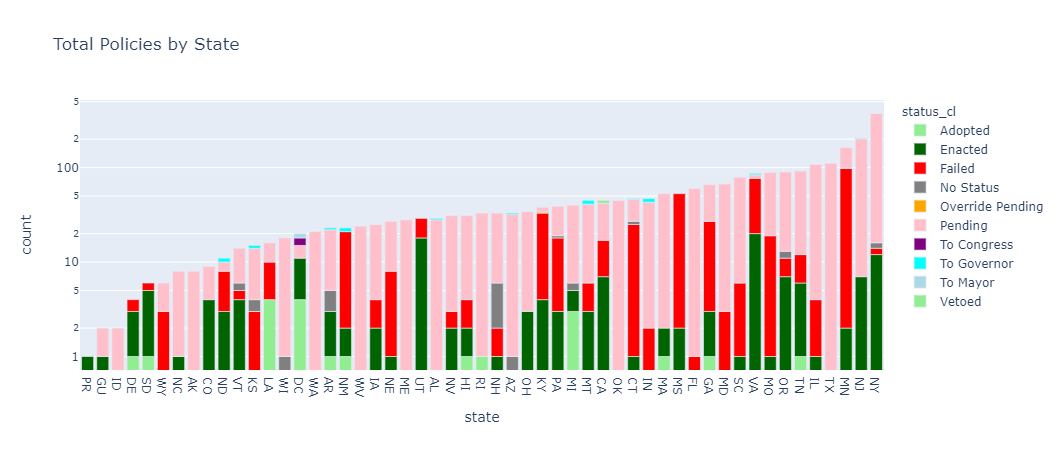

In [673]:
import plotly.express as px
fig = px.bar(state_policies_stat, x="state", y="count", color="status_cl", title="Total Policies by State", log_y=True, 
             color_discrete_sequence = ['lightgreen', 'darkgreen', 'red', "grey", "orange", "pink", "purple", "cyan", "lightblue"])
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':state_policies_stat.sort_values(["tot_policies"])['state'].values})
fig.show()

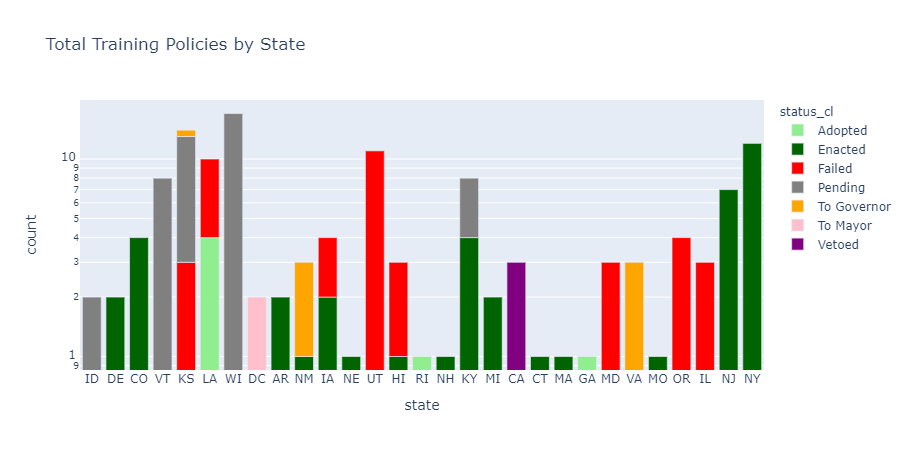

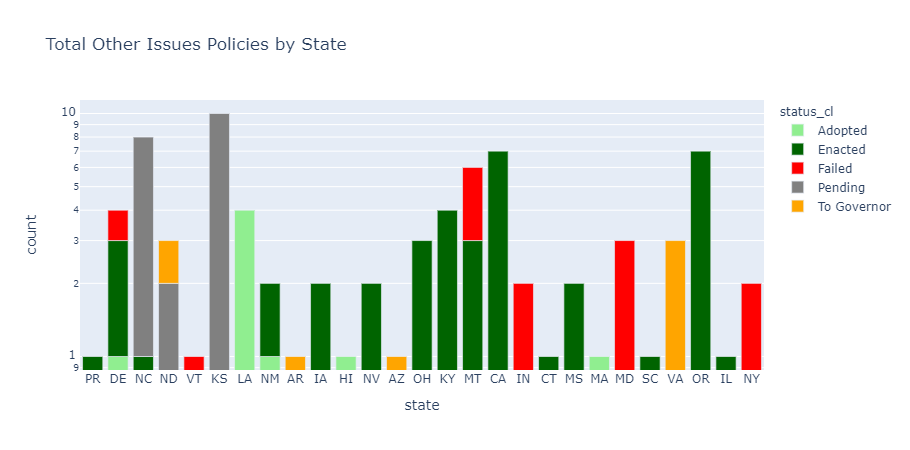

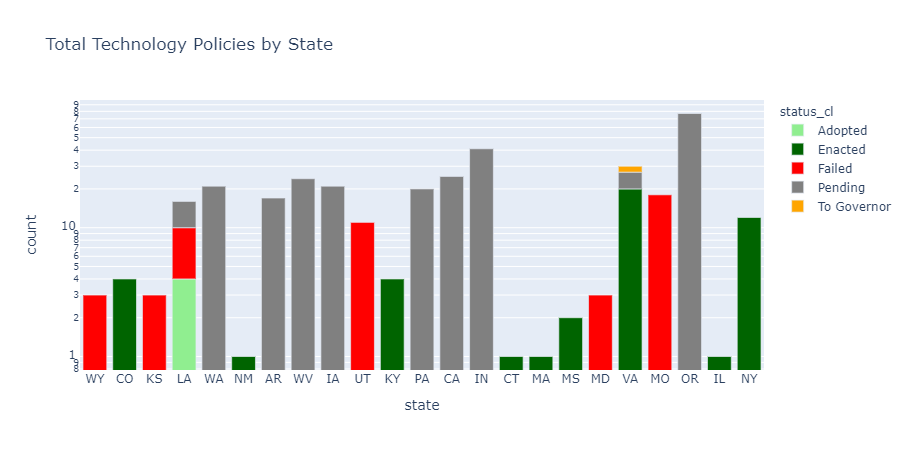

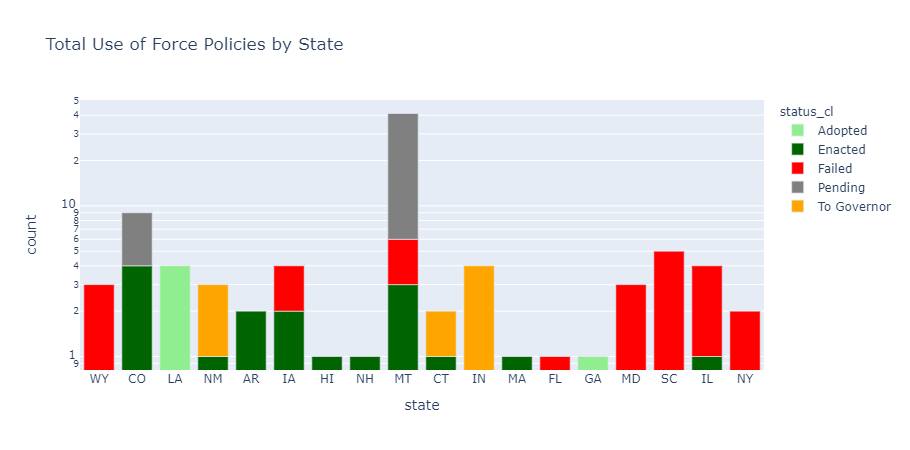

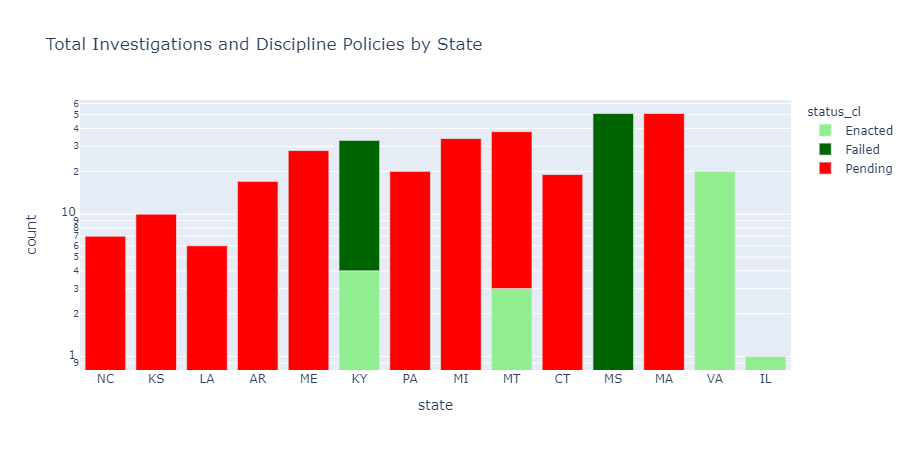

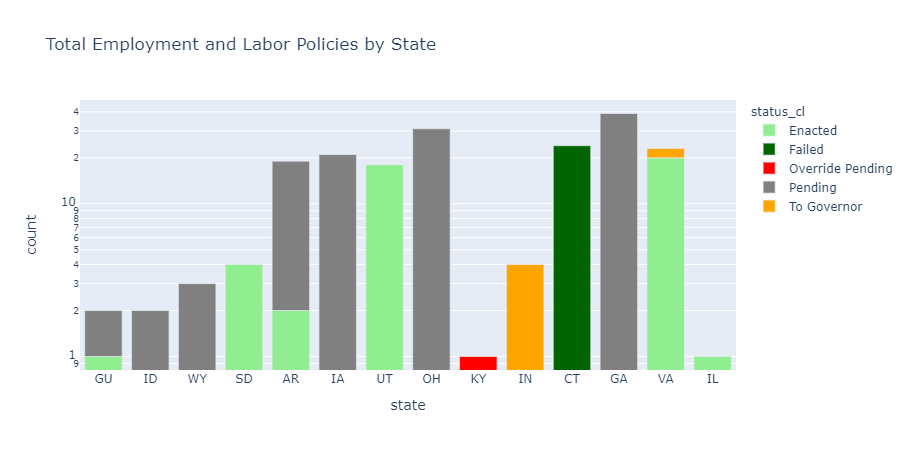

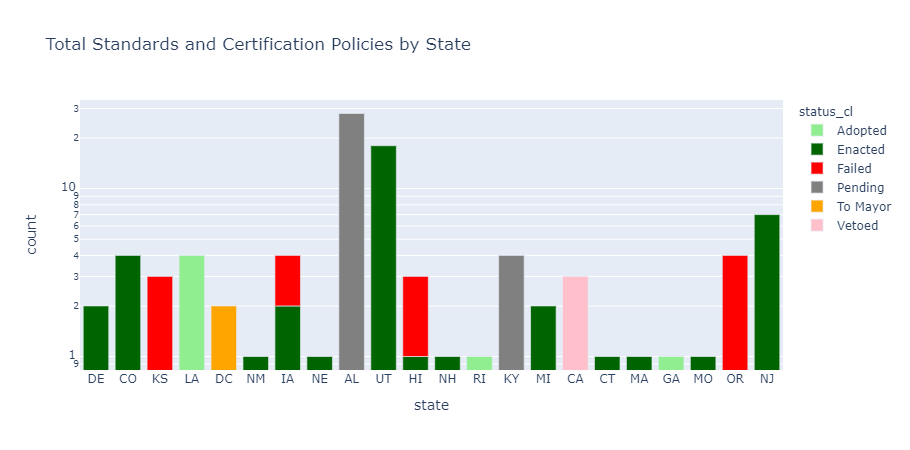

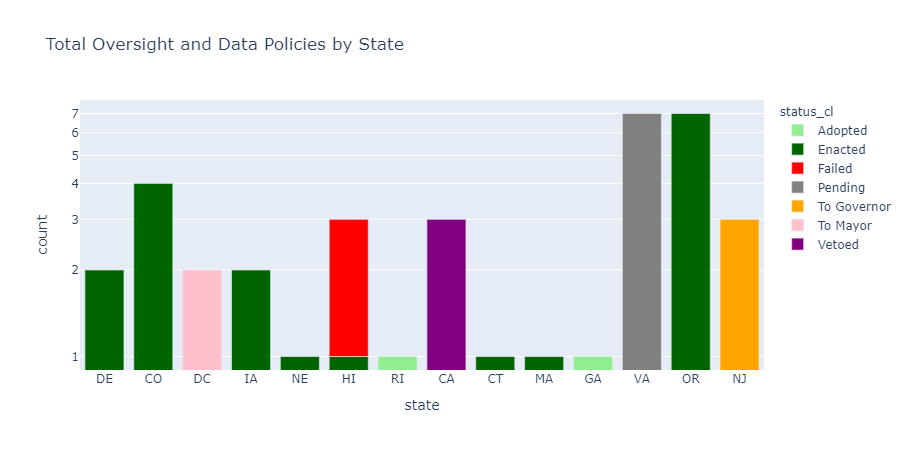

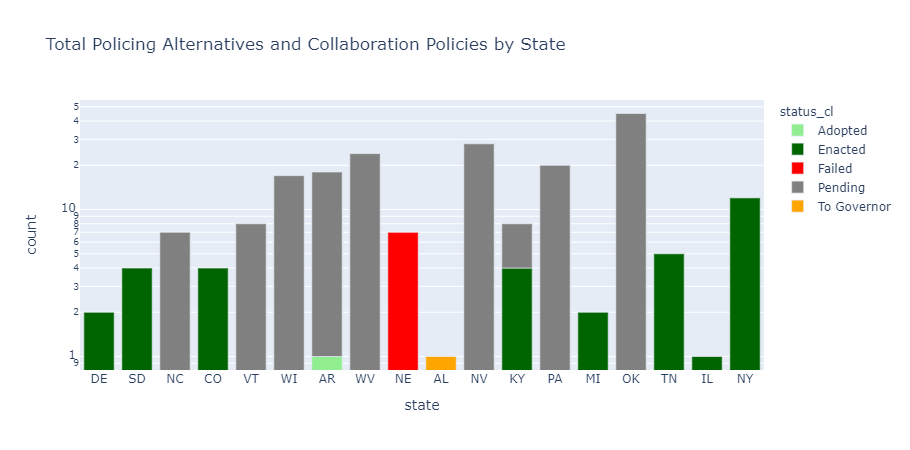

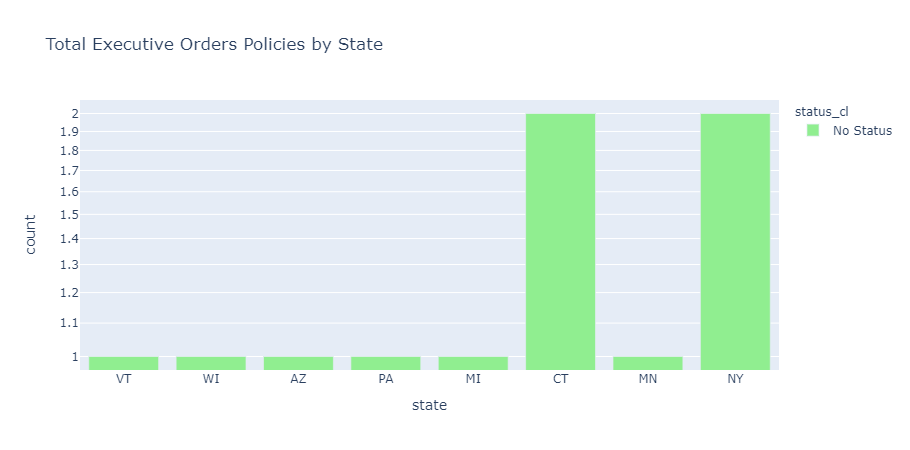

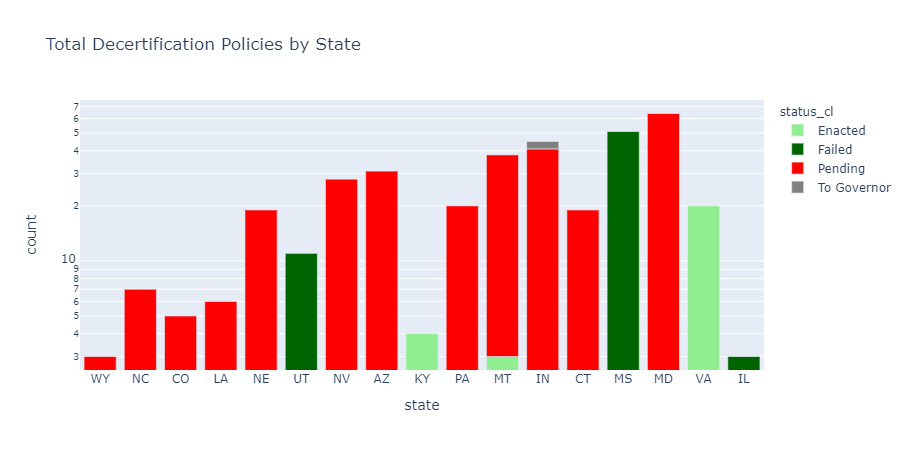

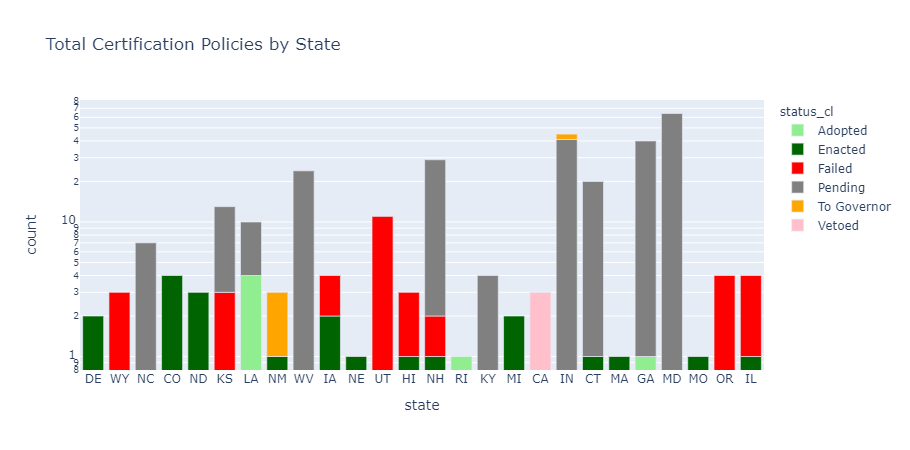

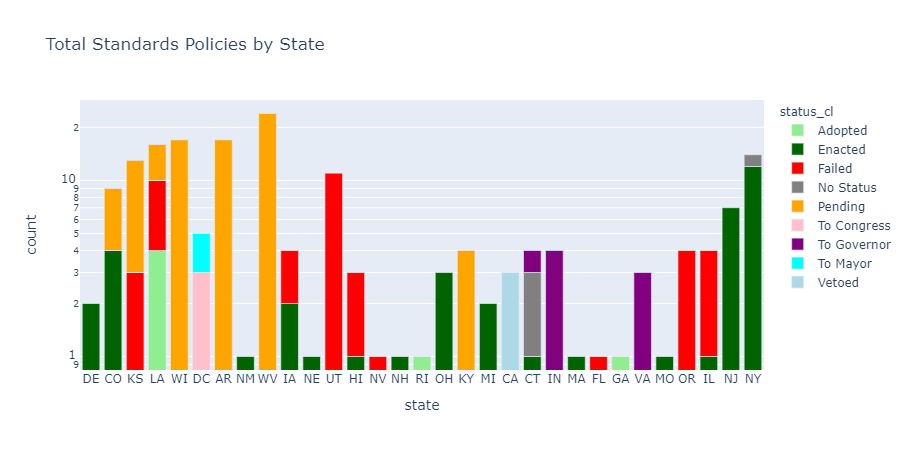

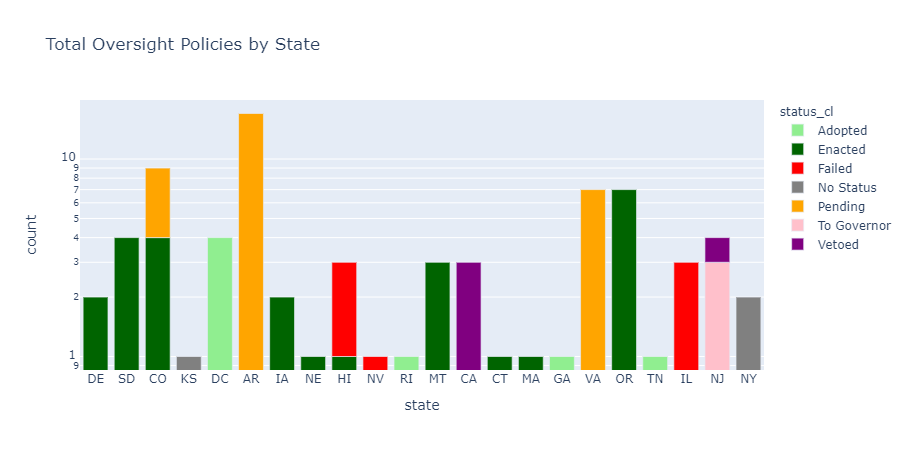

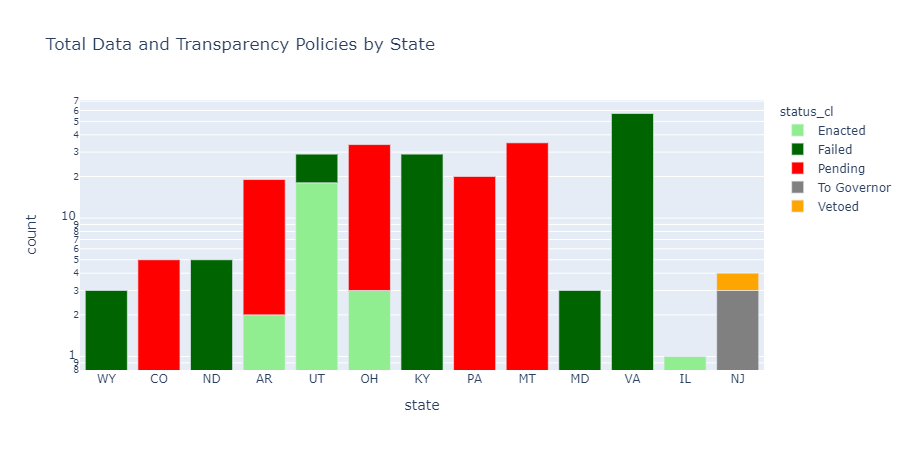

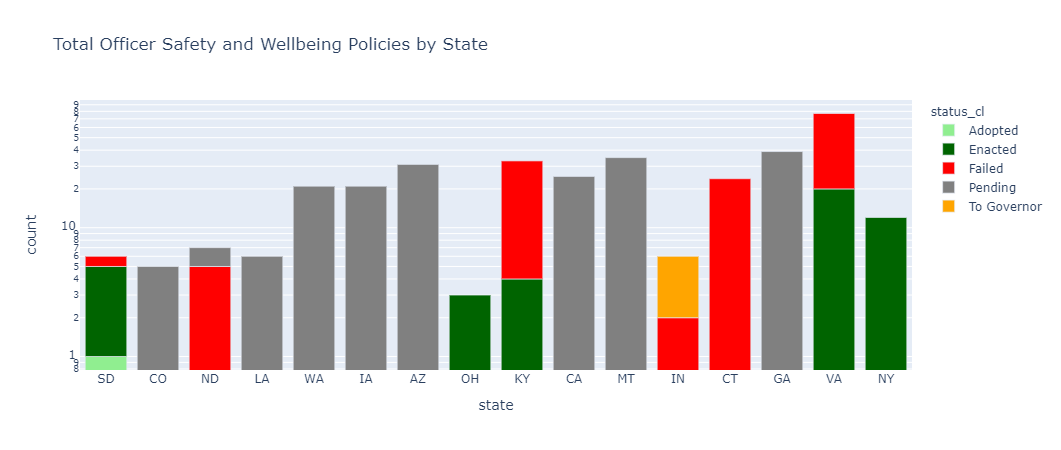

In [674]:
for topic in unique_topics:
    fig = px.bar(state_policies_stat[state_policies_stat[topic]==1], x="state", y="count", color="status_cl", title=f"Total {topic} Policies by State", log_y=True, 
                 color_discrete_sequence = ['lightgreen', 'darkgreen', 'red', "grey", "orange", "pink", "purple", "cyan", "lightblue"])
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': state_policies_stat[state_policies_stat[topic]==1].sort_values(["tot_policies"])['state'].values})
    fig.show()

In [687]:
# tweet data
# tweets_geo = gpd.read_file("../data/raw/processed/tweets_gdf_fs.geojson")
# protest data
df_p = pd.read_excel("../data/raw/protests/USA_2020_2021_Feb12.xlsx")
state_vote = pd.read_csv("../data/raw/processed/state_vote_stats.csv")
# df_p = pd.read_excel('../USA_2020_2021_Feb12.xlsx')
df_p['protest_count'] = 1
df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'])
df_p = df_p[(df_p['ASSOC_ACTOR_1'] == "BLM: Black Lives Matter")&(df_p['EVENT_DATE'] > "2020-05-25")]

state_abbrv = gpd.read_file("../data/raw/us_admin/us_abbrv.csv") #https://worldpopulationreview.com/states/state-abbreviations
state_pop = gpd.read_file("../data/raw/us_admin/nst-est2019-alldata.csv") #https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
state_geo = gpd.read_file("../data/raw/us_admin/cb_2018_us_state_500k.shp")[["STUSPS", "geometry"]]
state_pop['POPESTIMATE2019'] = pd.to_numeric(state_pop['POPESTIMATE2019'])
state_pop = pd.merge(state_pop, state_abbrv, left_on="NAME", right_on='State')[['Code', 'POPESTIMATE2019']]

In [131]:
# state_protests_stat = pd.merge(df_p.groupby('ADMIN1', as_index=False).sum()[['ADMIN1', 'protest_count']].rename(columns={"ADMIN1":"State"}), state_abbrv, on="State")[["Code", "protest_count"]].rename(columns={"Code":"state"})

In [134]:
# pd.merge(state_tweets_stat, state_protests_stat, on = "state")

In [138]:
# state_tweets_stat = state_tweets_stat.drop("POPESTIMATE2019_y", axis=1).rename(columns={"POPESTIMATE2019_x": "POPESTIMATE2019"})

In [688]:
# tweets_geo['state'] = tweets_geo['location_cl'].str.split(",").str[-1].str.strip(" ")
tweets_geo['tweet_count'] = 1
# state_tweets_stat = tweets_geo.groupby("state").sum().reset_index()[['state', 'tweet_count']]
# state_geo = state_geo.to_crs(tweets_geo.crs)
state_tweets_stat = gpd.sjoin(tweets_geo.dropna()[['tweet_count', 'geometry']], state_geo, how="inner").groupby("STUSPS", as_index=False).sum()[['STUSPS', "tweet_count"]]
state_tweets_stat.columns = ['state', 'tweet_count']
state_protests_stat = pd.merge(df_p.groupby('ADMIN1', as_index=False).sum()[['ADMIN1', 'protest_count']].rename(columns={"ADMIN1":"State"}), state_abbrv, on="State")[["Code", "protest_count"]].rename(columns={"Code":"state"})

state_tweets_stat = pd.merge(state_tweets_stat, state_pop, left_on= "state", right_on="Code").drop("Code", axis=1)
state_tweets_stat = pd.merge(state_tweets_stat, state_protests_stat, on = "state")

state_tweets_stat = pd.merge(state_tweets_stat, state_vote, on = "state")
state_tweets_stat.POPESTIMATE2019 = pd.to_numeric(state_tweets_stat.POPESTIMATE2019)

state_tp_stat_all['2016_2020_turnout_change'] = (state_tp_stat_all['total_votes_2020'] - state_tp_stat_all['total_votes_2016'])/state_tp_stat_all['total_votes_2016']
state_tweets_stat['tweets_100k'] = (pd.to_numeric(state_tweets_stat['tweet_count'])/pd.to_numeric(state_tweets_stat['POPESTIMATE2019']))*100000
state_tweets_stat['protests_100k'] = (pd.to_numeric(state_tweets_stat['protest_count'])/pd.to_numeric(state_tweets_stat['POPESTIMATE2019']))*100000

state_tp_stat_all = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_pass = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Adopted', 'Enacted'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_fail = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Failed', 'Vetoed'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_out = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").mean().reset_index()[['state', "tot_policies", "tot_failed", "tot_success", "tot_outcome"]], on="state")
state_tp_stat_out['policy_success_rate'] = state_tp_stat_out['tot_success']/state_tp_stat_out['tot_outcome']
state_tp_stat_out['policy_failure_rate'] = state_tp_stat_out['tot_failed']/state_tp_stat_out['tot_outcome']
state_tp_stat_out['success_cat'] = ""
state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']>=state_tp_stat_out['policy_success_rate'].mean()] = "More Successful Policies"
state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']<state_tp_stat_out['policy_success_rate'].mean()] = "More Failed Policies"

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1047]:
# state tweets/protests over time
state_tweets_time = gpd.sjoin(tweets_geo.dropna(), state_geo, how="inner").groupby(["STUSPS", "created_at_day"], as_index=False).sum().rename(columns={"created_at_day":"date", "STUSPS":"state"})[['state', 'date', "tweet_count"]]
state_protests_time = pd.merge(df_p[df_p['EVENT_DATE'] < "2020-11-10"].rename(columns={"ADMIN1":"State"}), state_abbrv, on="State").rename(columns={"Code":"state", "EVENT_DATE":"date"})[['state', "date", 'protest_count']]

In [1074]:
state_tp_time = pd.merge(state_tweets_time, state_protests_time, on=["state", "date"])
state_tp_time["date"] = state_tp_time.date.astype("str").str[:7]
state_tp_time = pd.merge(state_tp_time.groupby(["state", "date"], as_index=False).sum(), state_pop, left_on ="state", right_on="Code").drop("Code", axis=1)

state_tp_time['tweets_100k'] = (pd.to_numeric(state_tp_time['tweet_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000
state_tp_time['protests_100k'] = (pd.to_numeric(state_tp_time['protest_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000

state_tp_time.to_csv("../data/raw/processed/state_tp_time.csv")

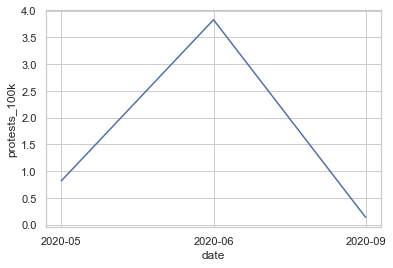

In [1083]:
sns.lineplot(data=state_tp_time[state_tp_time["state"]=="AK"], x="date", y="protests_100k")

In [1075]:
state_tp_time

,state,date,tweet_count,protest_count,POPESTIMATE2019,tweets_100k,protests_100k
0,AK,2020-05,215,6,731545,29.389853,0.820182
1,AK,2020-06,726,28,731545,99.242015,3.827516
2,AK,2020-09,1,1,731545,0.136697,0.136697
3,AL,2020-05,4067,17,4903185,82.946085,0.346713
4,AL,2020-06,9058,59,4903185,184.737064,1.203299
...,...,...,...,...,...,...,...
291,WV,2020-10,4,1,1792147,0.223196,0.055799
292,WY,2020-05,44,5,578759,7.602474,0.863917
293,WY,2020-06,412,32,578759,71.186798,5.529072
294,WY,2020-07,1,1,578759,0.172783,0.172783


In [352]:
# px.scatter(state_tp_stat_all, x = "count", y="tweets_100k", log_y=True, log_x=True, hover_data=['state', 'tweets_100k', 'count'])

In [351]:
# px.scatter(state_tp_stat_all[state_tp_stat_all['state']!="DC"], x = "count", y="tweets_100k", log_x=True, hover_data=['state', 'tweets_100k', 'count'])

## Simple regression analysis (no generalization)

### tweets vs. legislature and protests vs. legislature

index measuring for each day distance between place with highest concentration of tweets and place with highest concentration of protests
make multiple regression plots:
- tweet at time t vs protest a time t+1, same with t+2, same with t+3... SPATIALLY
- plot networks in space: maybe tweets spatially close together are part of the same highly connected subgraph --> would explain the spatial relation

In [1023]:
# fig = sns.regplot(data = state_tp_stat_all, x = "tweets_100k", y = "per_dem_2020", scatter_kws={"s": 60}, ci=None)
# fig.set_xscale("log")

In [1025]:
state_tp_stat_all[['state', 'tweets_100k', 'protests_100k', 'count', "2016_2020_turnout_change"]].to_csv("../data/raw/processed/state_tpv_policies.csv")

In [1030]:
# state_tp_stat_all[['state', 'tweets_100k', 'protests_100k', 'count', "2016_2020_turnout_change"]].sort_values("tweets_100k")

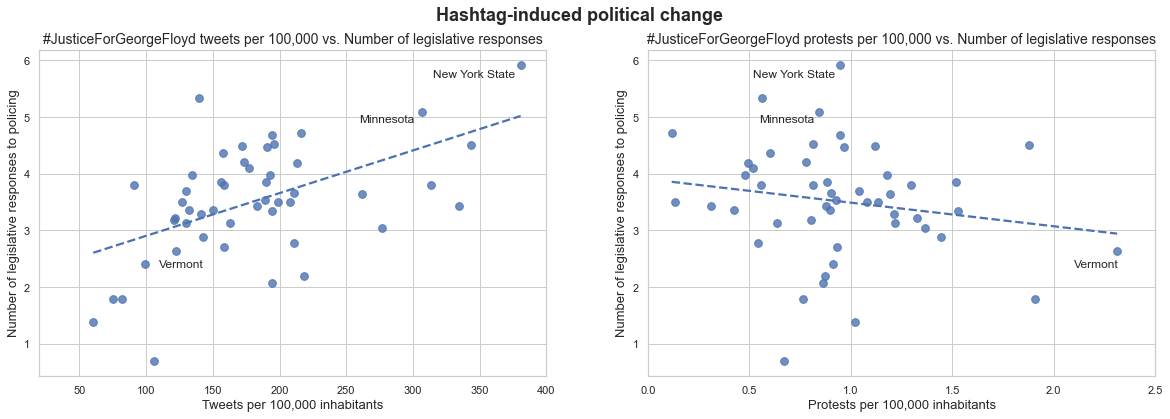

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.527                                                              Pearson Correlation = -0.18
R^2 score = 0.278                                                                        R^2 score = 0.032


In [984]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,6))

df = state_tp_stat_all[state_tp_stat_all['state']!="DC"][['state', 'tweets_100k', 'protests_100k', 'count', "2016_2020_turnout_change"]] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'][:, None])
X_t = df.tweets_100k
X_p = np.log(df.protests_100k)


sns.regplot(ax = ax[0], data = df, x = X_t, y = y, scatter_kws={"s": 60}, ci=None)
sns.regplot(ax = ax[1], data = df, x = X_p, y = y, scatter_kws={"s": 60}, ci=None)
ax[0].lines[0].set_linestyle("--")
ax[1].lines[0].set_linestyle("--")
ax[0].set(xlim=(20, 400))
ax[1].set(xlim=(0, 2.5))
# text annotations
plt.suptitle("Hashtag-induced political change", fontsize=18, fontweight='bold')
# plt.title("Tweeting density vs. protest density vs. number of legislative responses", fontsize=18)

ax[0].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[1].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[0].set_xlabel("Tweets per 100,000 inhabitants", fontsize=13)
ax[1].set_xlabel("Protests per 100,000 inhabitants", fontsize=13)

ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Number of legislative responses", fontsize=14)
ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Number of legislative responses", fontsize=14)


# regression scores
slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))
slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# ax[0].plot(380, 5.5, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)

ax[0].annotate(f"New York State", xy=(315, 5.7), xytext=(315, 5.7))
ax[1].annotate(f"New York State", xy=(0.52, 5.7), xytext=(0.52, 5.7))
ax[0].annotate(f"Minnesota", xy=(260, 4.9), xytext=(260, 4.9))
ax[1].annotate(f"Minnesota", xy=(0.55, 4.9), xytext=(0.55, 4.9))
ax[0].annotate(f"Vermont", xy=(110, 2.35), xytext=(110, 2.35))
ax[1].annotate(f"Vermont", xy=(2.1, 2.35), xytext=(2.1, 2.35))

plt.show()
print("-"*110)
print(f"Pearson Correlation = {r_value_t.round(3)}", " "*60, f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}", " "*70, f"R^2 score = {(r_value_p**2).round(3)}")

In [802]:
import statsmodels.api as sm

y = sm.add_constant(y, prepend=False)
mod = sm.OLS(X_t, y)
res = mod.fit()
print(res.summary())

y = sm.add_constant(y, prepend=False)
mod = sm.OLS(X_p, y)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            tweets_100k   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     18.07
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           0.000100
Time:                        23:27:46   Log-Likelihood:                -269.09
No. Observations:                  49   AIC:                             542.2
Df Residuals:                      47   BIC:                             546.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            36.8337      8.666      4.251      0.0

### tweets vs. turnout and protests vs. turnout

In [698]:
# state_tp_stat_all

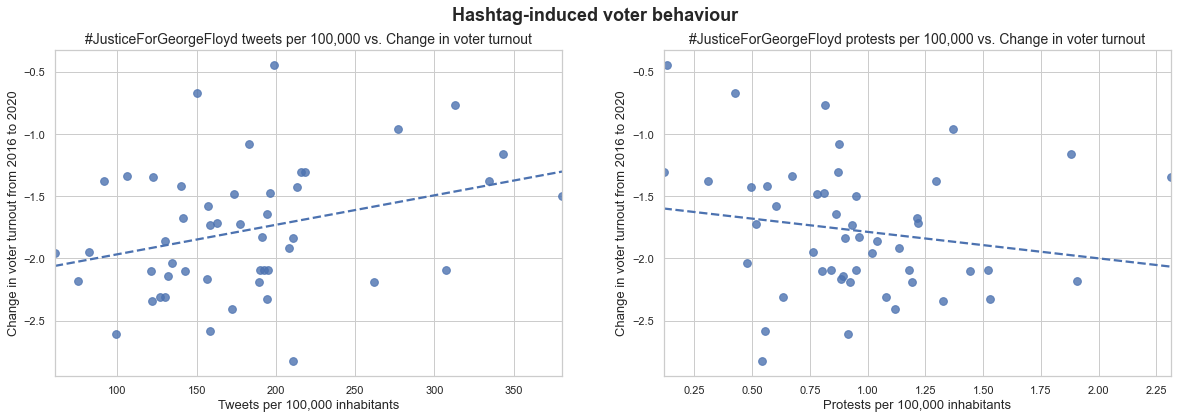

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.32                                                              Pearson Correlation = -0.177
R^2 score = 0.102                                                                        R^2 score = 0.031


In [999]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy
sns.set(style ="whitegrid", font_scale=1)

fig, ax = plt.subplots(1, 2, figsize=(20,6))

df = state_tp_stat_all[state_tp_stat_all['state']!="DC"][['tweets_100k', 'protests_100k', '2016_2020_turnout_change']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['2016_2020_turnout_change'][:, None])
X_t = df.tweets_100k
X_p = np.log(df.protests_100k)


sns.regplot(ax = ax[0], data = df, x = X_t, y = y, scatter_kws={"s": 60}, ci=None)
sns.regplot(ax = ax[1], data = df, x = X_p, y = y, scatter_kws={"s": 60}, ci=None)
ax[0].lines[0].set_linestyle("--")
ax[1].lines[0].set_linestyle("--")
# ax[0].set(xlim=(20, 400), ylim=(0,))
# ax[1].set(xlim=(0, 2.5), ylim=(0,))
# ax[0].set(xlim=(20, 400))
# ax[1].set(xlim=(0, 2.5))
# text annotations
plt.suptitle("Hashtag-induced voter behaviour", fontsize=18, fontweight='bold')
# plt.title("Tweeting density vs. protest density vs. number of legislative responses", fontsize=18)

ax[0].set_ylabel("Change in voter turnout from 2016 to 2020", fontsize=13)
ax[1].set_ylabel("Change in voter turnout from 2016 to 2020", fontsize=13)
ax[0].set_xlabel("Tweets per 100,000 inhabitants", fontsize=13)
ax[1].set_xlabel("Protests per 100,000 inhabitants", fontsize=13)

ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

# legend
# ax[0].plot(-1, 100, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)

# ax[0].annotate(f" = 1 day", xy=(-0.95, 96), xytext=(-0.95, 96))

# regression scores
slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))
slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# style = dict(size=10, color='gray')
# ax[0].text(1, 350, f"R^2 score = {r_value_t**2}", **style)
# ax[1].text(1, 350, f"R^2 score={r_value_p**2}", **style)
plt.show()
print("-"*110)
print(f"Pearson Correlation = {r_value_t.round(3)}", " "*60, f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}", " "*70, f"R^2 score = {(r_value_p**2).round(3)}")

## ML regression analysis (model generalization)

#### Tweets vs Policy Count

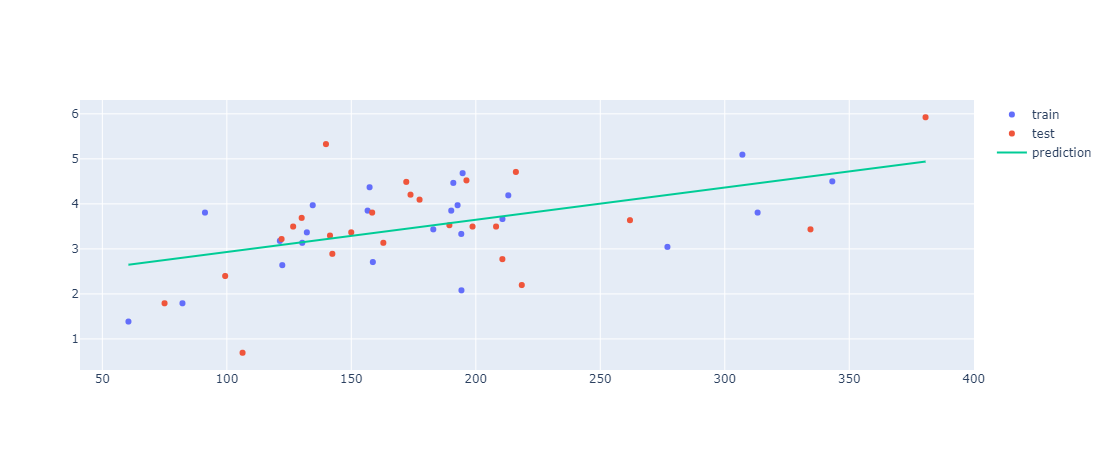

intercept: 2.22
slope: 0.01
MSE: 0.86
RMSE: 0.93
R2:	 0.249


In [906]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

df = state_tp_stat_all[state_tp_stat_all['state']!="DC"][['tweets_100k', 'count']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'])
# y = np.log(df.tweets_100k)

# X = df['count'][:, None]
X = df[['tweets_100k']]

# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range).reshape(-1)


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range.reshape(-1), y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [925]:
# cross validation
folds = KFold(n_splits = 2, shuffle = True, random_state = 0)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.282


#### Protests vs Policy Count

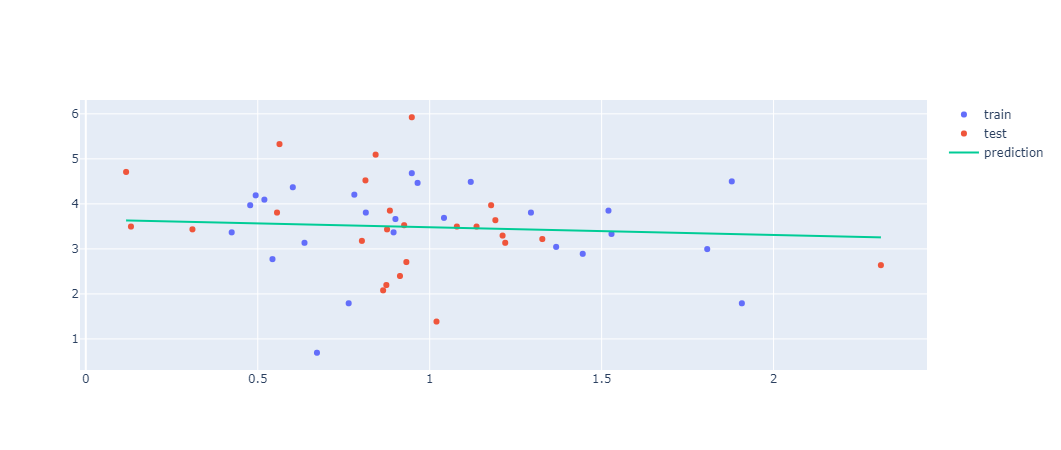

intercept: 3.65
slope: -0.17
MSE: 1.0
RMSE: 1.0
R2:	 0.037


In [962]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
import numpy as np

df = state_tp_stat_all[['protests_100k', 'count']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'][:, None]).reshape(-1)
X = np.log(df.protests_100k[:, None])

# X = df['count'][:, None]
# y = df.protests_100k
# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
# model.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test.reshape(-1, 1))

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [972]:
# cross validation
folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.024


### Time Series

[Text(0.5, 0, '')]

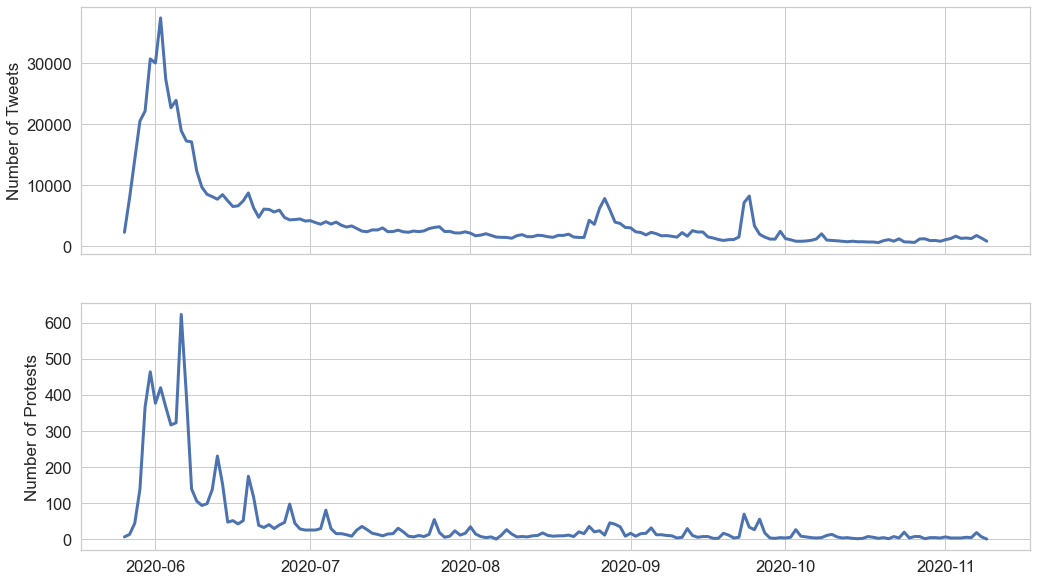

In [993]:
# tweets_geo = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
sns.set(style ="whitegrid", font_scale=1.5)
# preprocess protest and tweet data
# tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
# tweets_geo['tweet_count'] = 1
# tweets_geo['created_at_day'] = pd.to_datetime(tweets_geo['created_at'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'], format='%Y-%m-%d')
df_p_t = pd.merge(tweets_geo[(tweets_geo['created_at_day']>="2020-05-26")&(tweets_geo['created_at_day']<="2020-11-09")].groupby('created_at_day').sum().reset_index().rename(columns={"created_at_day":"date"}),
         df_p[(df_p['EVENT_DATE']>="2020-05-26")&(df_p['EVENT_DATE']<="2020-11-09")].groupby('EVENT_DATE').sum().reset_index().rename(columns={"EVENT_DATE":"date"})[['date', 'protest_count']])

fig, ax = plt.subplots(2,1, figsize=(17,10))
g1 = sns.lineplot(ax = ax[0], data = df_p_t, x = 'date', y = 'tweet_count', linewidth = 3)
g2 = sns.lineplot(ax = ax[1], data = df_p_t, x = 'date', y = 'protest_count', linewidth = 3)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("Number of Tweets", fontsize=17)
ax[1].set_ylabel("Number of Protests", fontsize=17)
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

In [1027]:
df_p_t.to_csv("../data/raw/processed/tweets_protests_time.csv")

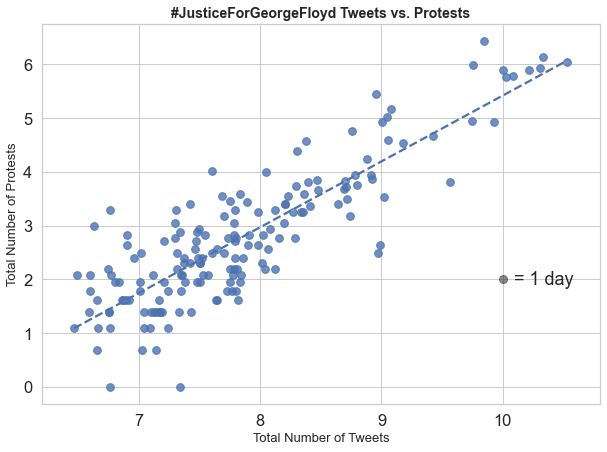

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.859
R^2 score = 0.738


In [997]:
fig, ax = plt.subplots(figsize=(10,7))

X = np.log(df_p_t['tweet_count'][:, None])
y = np.log(df_p_t['protest_count'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(data = df_p_t, x = X, y = y, scatter_kws={"s": 60}, ci=False)
# ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

ax.set(xlim=(6.2, 10.8))
# ax.set_xlim(2000,)

# ax.set_xlim(auto=True)

ax.lines[0].set_linestyle("--")

ax.set_xlabel("Total Number of Tweets", fontsize=13)
ax.set_ylabel("Total Number of Protests", fontsize=13)
ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

# regression metrics
slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

# annotations
style = dict(size=11)
# ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
# ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

# legend
ax.plot(10, 2, 'o',
        ms=8, mec='k', color="k", alpha=0.5)

ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


plt.show()

print("-"*110)
print(f"Pearson Correlation = {r_value.round(3)}")
print(f"R^2 score = {(r_value**2).round(3)}")

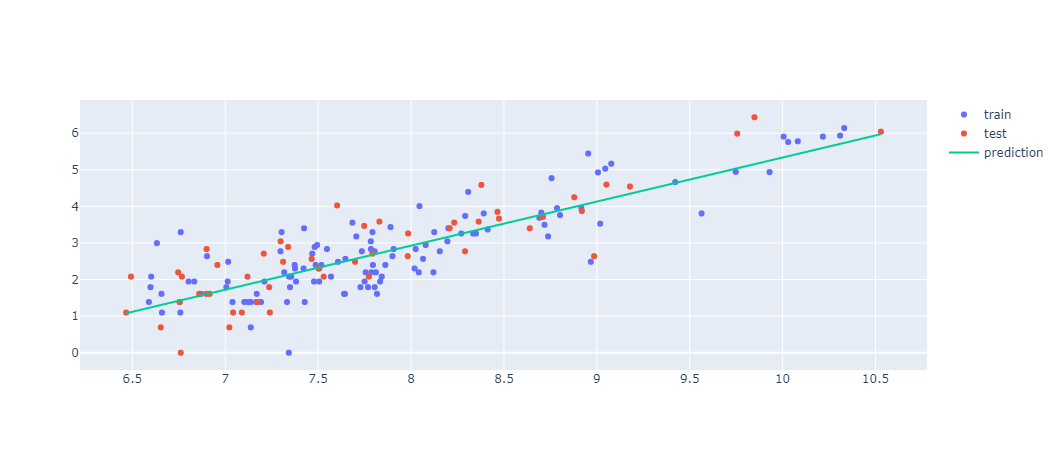

intercept: -6.71
slope: 1.2
MSE: 0.47
RMSE: 0.68
R2:	 0.75


In [604]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

df = df_p_t #[state_tp_stat_all['state']!="DC"]
X = np.log(df_p_t['tweet_count'][:, None])
y = np.log(df_p_t['protest_count'])

# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test.reshape(-1, 1))

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [608]:
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.724


In [597]:
# sns.set()

# fig, ax = plt.subplots(figsize=(10, 8))

# data = df_p_t

# sns.regplot(x=np.log10(data['tweet_count']), y=np.log10(data['protest_count']),
#             scatter_kws={'s': 80, 'alpha': 0.5}, ax=ax)

# ax.set_ylabel('Platform1', labelpad=15, fontsize=15)
# ax.set_xlabel('Platform2', labelpad=15, fontsize=15)
# ax.set_title('Sales of the same game in different platforms', pad=30, size=20)

# xticks = ndata['tweet_count'].sample(5))
# yticks = np.log10(data['protest_count'].sample(5))

# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# formatter = lambda x, pos: f'{10 ** x:g}'
# ax.get_xaxis().set_major_formatter(formatter)
# ax.get_yaxis().set_major_formatter(formatter)
# lims = np.log10(np.array([0.005, 25.]))
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# plt.show()

In [504]:
# px.scatter(state_tp_stat_pass[state_tp_stat_pass['state']!="DC"], x = "count", y="tweets_100k", log_x=True, hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019")

In [505]:
# px.scatter(state_tp_stat_fail, x = "count", y="tweets_100k", hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019", log_x=True)

In [506]:
# px.scatter(state_tp_stat_out[(state_tp_stat_out['state']!="DC")&(state_tp_stat_out['tot_outcome']>1)], x = "policy_success_rate", y="tweets_100k", hover_data=['state', 'tweets_100k', 'policy_success_rate'], size = "POPESTIMATE2019")

In [507]:
# px.scatter(state_tp_stat_out[(state_tp_stat_out['state']!="DC")&(state_tp_stat_out['tot_outcome']>1)], x = "policy_failure_rate", y="tweets_100k", hover_data=['state', 'tweets_100k', 'policy_failure_rate'], size = "POPESTIMATE2019")

In [686]:
# px.box(state_tp_stat_out[(state_tp_stat_out['success_cat']!="")], x = "success_cat", y="tweets_100k", 
#        hover_data=['state', 'tweets_100k', 'policy_success_rate'], color = 'success_cat', color_discrete_sequence = ['darkgreen', 'red'],
#        points = "all", log_y=True)
# # fig.add_trace(px.strip(x='success_cat', y='tweets_100k'))
# # fig.show()

In [415]:
# state_tp_stat_out

In [297]:
# soup = BeautifulSoup(open(fr"C:/Users/Leonardo/OneDrive/Documents/TU_Delft/CodingProjects/PoliceBrutality/data/raw/NCLS/2020_policies.html"), "html.parser")
#     # clean html and convert policies to list of strings
# policies = soup.find_all('div', id = "dnn_ctr93953_StateNetDB_linkList")[0].text.split('\n')

In [296]:
# policies_str = list(filter(None,[el.replace('  ','') for el in list(filter(None, policies))]))
# policies_str_cl = [el for el in policies_str if "Text Lookup" not in el]
# print("There were", len([policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']), "state policies related to policing in 2021.")

In [193]:
# state_abbrv = [state.abbr for state in us.STATES]

In [295]:
# len([el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20])

In [289]:
# # extract all info of interest
# # policy_id = [el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# policy_id = [policies_str_cl[i-3] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# # state = [el[:2] for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# state = [el[:2] for el in policy_id]
# year = [el for el in policies_str_cl if el.startswith("2021") or el.startswith("2020")]
# status = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# DOLA = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Date of Last Action:*\xa0']
# author = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Author:']
# topics = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Topics: ']
# summary = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Summary: ']
# history = [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']

# df_data = {"policy_id": policy_id, "state": state, "year": year, "status": status, 
#            "date_of_last_action": DOLA, "author": author, "topics": topics, "summary": summary, "history": history}

# df_policies = pd.DataFrame.from_dict(df_data)

In [290]:
# policies_str_cl[:100]

In [291]:
# [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']